In [ ]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [ ]:
# for execution in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# System imports
from os import path
import math

!pip install ffmpeg-python # for converting to video
!pip install ipympl
!pip install mplcursors # for interactive point selection on images

# Third-Party Imports
import cv2
import ffmpeg
import matplotlib.pyplot as plt
import mplcursors
import numpy as np

# project directory
datadir = "./"

# utils location
utilfn = datadir + "utils.py"
!cp "$utilfn" .
import utils

# sample images directory
imagesfn = datadir + "images/"
!cp -r "$imagesfn" .

# output/results directory
outputfn = datadir + "output/"
!cp -r "$outputfn" .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00


# Method 2.1: Image Morphing with Delaunay Triangulation


In [ ]:
def DisplayTriangulation(im, tris, lw=1.0):
    '''
    will want this for testing
    '''
    plt.figure()
    plt.imshow(im[:,:,[2,1,0]])
    for t in tris:
        t = np.vstack((t, t[0]))
        plt.plot(t[:,0], t[:, 1], 'r-', linewidth=lw)

In [ ]:
from matplotlib.path import Path

def GetTriangulations(W, H, pts1, pts2):
    # compute DT for im1
    rect = (0,0,W,H)
    subdiv1 = cv2.Subdiv2D(rect)
    subdiv1.insert([tuple(map(int,pt)) for pt in pts1])   # turn np.ndarray into list of tuples
    tris1 = subdiv1.getTriangleList()
    tris1 = tris1.reshape((tris1.shape[0],3,2))     # each row of a triangle is a vertex (x,y)

    # map to im2
    tris2 = []
    for t1 in tris1:
        x1,y1,z1 = t1.tolist()  # weird fix, makes the .index() method work
        x2 = pts2[pts1.index(x1)]
        y2 = pts2[pts1.index(y1)]
        z2 = pts2[pts1.index(z1)]

        tris2.append(np.vstack((x2,y2,z2)))

    tris2 = np.array(tris2)
    return tris1, tris2



def GetTransform(t1, t2):
    # Returns affine transformation mapping t1 to t2
    # following conventions from: https://math.stackexchange.com/questions/1092002/how-to-define-an-affine-transformation-using-2-triangles
    A = np.vstack((t1.T, np.ones(3)))
    X = np.vstack((t2.T, np.ones(3)))
    if np.abs(np.linalg.det(A)) < 1e-10:    # in case one of the triangles has 0 area / is invalid
      return -1
    return X @ np.linalg.inv(A)



def ProjectTriangle(im, t_im, t_plane):
    # NOTE FOR TESTING:
    #     - verify triangle mappings are 'bijective'
    #     - should fill space they are mapped to and not exceed boundaries
    #     - images will generate regardless but it will not give the desired effect
    # UPDATE:
    #     this is in fact a property of the affine transformation between triangles
    # also lot of ChatGPT for array manipulation stuff that should be verified
    H,W,_ = im.shape

    # extract points inside t_plane triangle
    # source: https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
    xs, ys = np.meshgrid(np.arange(W), np.arange(H)) # make a canvas with coordinates
    xs, ys = xs.flatten(), ys.flatten()
    points = np.vstack((xs,ys)).T

    vertex_tuples = [tuple(map(int, v)) for v in t_plane]
    p = Path(vertex_tuples) # make a polygon
    grid = p.contains_points(points)
    mask = np.array(grid.reshape((H,W)))

    # get transformation
    Hom = GetTransform(t_im, t_plane)
    if type(Hom)==int:
        print('singular matrix found; passing triangle')
        return np.zeros_like(im)

    # apply projection and mask out the triangle
    warped = cv2.warpPerspective(im, Hom, (W,H))
    result = warped * mask[:,:,np.newaxis]

    return result


def DelaunayMorphing(im1, im2, pts1, pts2, num_steps):
    '''
    returns list of frames gradually morphing im1 to im2.

    Args:
      - im1,im2 (np.ndarray): initial and final images, both of shape (H,W,3)
      - pts1, pts2 (np.ndarray): (N,2) shaped arrays representing key feature locations in images (i.e. pts1[i,:] and pts2[i,:] corr. w/ same feature)
      - num_steps (int):
    Returns:
      - (np.ndarray): frames to be made into morphing video, shape (num_steps+1, H, W, 3)

    Steps to implement:
    1. Compute Delaunay triangulations of each image
        - only for im1 then just map triangles to their corr. features in im2 so triangles can be matched up
    2. For each time step...
        a) interpolate between locations of key pts
        b) project triangles from each im to their intermediate correspondents
        c) interpolate between projected pixels
    '''
    # sanity check
    assert im1.shape == im2.shape

    # for efficiency
    if im1.dtype == 'float32' and im2.dtype == 'float32':
        im1 = (im1*255).astype(np.uint8)
        im2 = (im2*255).astype(np.uint8)

    H,W,_ = im1.shape
    frames = np.zeros((num_steps+1, H, W, 3), dtype=np.uint8)


    # step 1
    tris1, tris2 = GetTriangulations(W, H, pts1, pts2)
    T = len(tris1)


    # step 2
    frames[0,:,:,:] = im1
    for iter in range(1,num_steps):
        print(f'frame #{iter}')
        t = (1.0 * iter) / num_steps

        # 2a
        tris_intrm = (1-t)*tris1 + t*tris2
        canvas = np.zeros_like(im1)
        for i in range(T):
            # 2b
            t1_proj = ProjectTriangle(im1, tris1[i], tris_intrm[i])
            t2_proj = ProjectTriangle(im2, tris2[i], tris_intrm[i])

            # 2c
            canvas += ((1-t)*t1_proj + t*t2_proj).astype(np.uint8)

        frames[iter,:,:,:] = canvas

    frames[-1,:,:,:] = im2

    return frames

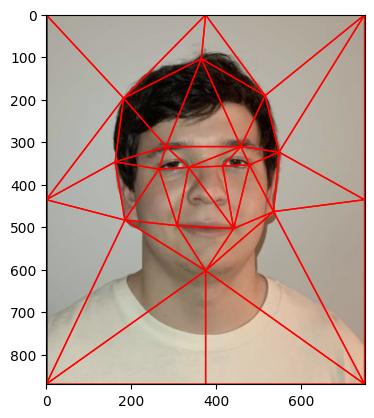

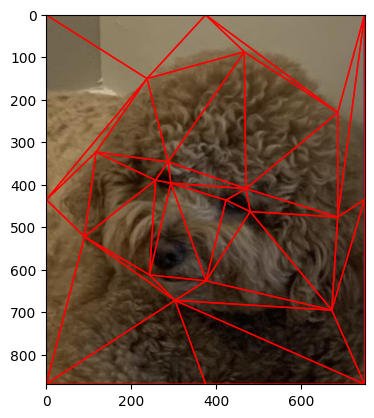

In [ ]:
pts1 = [[265, 363], [335, 359], [415, 356], [478, 353], [282, 310], [458, 310], [308, 496], [441, 503], [185, 483], [535, 463], [162, 346], [548, 323], [182, 196], [365, 103], [515, 190], [375, 602], [0, 0], [0, 435], [0, 869], [375, 869], [749, 869], [749, 435], [749, 0], [375, 0]]
pts2 = [[257, 389], [293, 396], [423, 436], [480, 463], [287, 346], [470, 409], [243, 612], [376, 626], [90, 522], [672, 695], [117, 323], [686, 476], [237, 150], [466, 87], [686, 230], [303, 672], [0, 0], [0, 435], [0, 869], [375, 869], [749, 869], [749, 435], [749, 0], [375, 0]]

im1 = cv2.imread(imagesfn+'matt.jpg')[:870,:750,:]
im2 = cv2.imread(imagesfn+'toby.jpg')[:870,-750:,:]
H,W,_ = im1.shape

t1,t2 = GetTriangulations(W,H,pts1,pts2)
DisplayTriangulation(im1,t1)
DisplayTriangulation(im2,t2)

frame #1


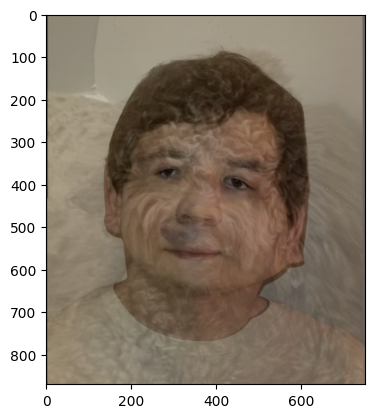

In [ ]:
# TESTING: only computing halfway interpolation between ims
im1 = cv2.imread(imagesfn+'matt.jpg')[:870,:750,:]
im2 = cv2.imread(imagesfn+'toby.jpg')[:870,-750:,:]
pts1 = [[265, 363], [335, 359], [415, 356], [478, 353], [282, 310], [458, 310], [308, 496], [441, 503], [185, 483], [535, 463], [162, 346], [548, 323], [182, 196], [365, 103], [515, 190], [375, 602], [0, 0], [0, 435], [0, 869], [375, 869], [749, 869], [749, 435], [749, 0], [375, 0]]
pts2 = [[257, 389], [293, 396], [423, 436], [480, 463], [287, 346], [470, 409], [243, 612], [376, 626], [90, 522], [672, 695], [117, 323], [686, 476], [237, 150], [466, 87], [686, 230], [303, 672], [0, 0], [0, 435], [0, 869], [375, 869], [749, 869], [749, 435], [749, 0], [375, 0]]

# pts1 = [[295, 356], [448, 346], [378, 506], [0, 0], [0, 869], [749, 869], [749, 0]]
# pts2 = [[277, 393], [443, 446], [280, 626], [0, 0], [0, 869], [749, 869], [749, 0]]

frames = DelaunayMorphing(im1, im2, pts1, pts2, 2)
plt.imshow(frames[1][:,:,[2,1,0]])

In [ ]:
# RESULT: full morphing
frames = DelaunayMorphing(im1, im2, pts1, pts2, 60)

frame #1
frame #2
frame #3
frame #4
frame #5
frame #6
frame #7
frame #8
frame #9
frame #10
frame #11
frame #12
frame #13
frame #14
frame #15
frame #16
frame #17
frame #18
frame #19
frame #20
frame #21
frame #22
frame #23
frame #24
frame #25
frame #26
frame #27
frame #28
frame #29
frame #30
frame #31
frame #32
frame #33
frame #34
frame #35
frame #36
frame #37
frame #38
frame #39
frame #40
frame #41
frame #42
frame #43
frame #44
frame #45
frame #46
frame #47
frame #48
frame #49
frame #50
frame #51
frame #52
frame #53
frame #54
frame #55
frame #56
frame #57
frame #58
frame #59


In [ ]:
# saving resul
utils.vidwrite_from_numpy(outputfn+'matt2toby_v2.mp4', frames[:,:,:,[2,1,0]], framerate=20)

In [ ]:
# saving some intermediate frames for demonstration
for i in [15,30,45]:
    print(f'writing to: '+outputfn+'matt2toby_f'+str(i)+'.png')
    cv2.imwrite(outputfn+'matt2toby_f'+str(i)+'.png', frames[i])

writing to: /content/drive/My Drive/CS445/final_morphing/output/hiatt2toby_f15.png
writing to: /content/drive/My Drive/CS445/final_morphing/output/hiatt2toby_f30.png
writing to: /content/drive/My Drive/CS445/final_morphing/output/hiatt2toby_f45.png
